In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
df = pd.read_csv('../data/clean_data.csv', index_col=0)
df.head()

,airline_sentiment,negativereason,airline,retweet_count,text,text_clean
0,positive,No Reason,Virgin America,0,@VirginAmerica plus you've added commercials t...,plus added commercial experience tacky
1,negative,Bad Flight,Virgin America,0,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
2,negative,Can't Tell,Virgin America,0,@VirginAmerica and it's a really big bad thing...,really big bad thing
3,negative,Can't Tell,Virgin America,0,@VirginAmerica seriously would pay $30 a fligh...,seriously pay flight seat did playing really b...
4,positive,No Reason,Virgin America,0,"@VirginAmerica yes, nearly every time I fly VX...",yes nearly time fly vx ear worm away


In [3]:
#Create new column where positive sentiment is 0, negative sentiment is 1
df['sentiment_num'] = df.airline_sentiment.map({'positive':1, 'negative':0})
df.head()

,airline_sentiment,negativereason,airline,retweet_count,text,text_clean,sentiment_num
0,positive,No Reason,Virgin America,0,@VirginAmerica plus you've added commercials t...,plus added commercial experience tacky,1
1,negative,Bad Flight,Virgin America,0,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...,0
2,negative,Can't Tell,Virgin America,0,@VirginAmerica and it's a really big bad thing...,really big bad thing,0
3,negative,Can't Tell,Virgin America,0,@VirginAmerica seriously would pay $30 a fligh...,seriously pay flight seat did playing really b...,0
4,positive,No Reason,Virgin America,0,"@VirginAmerica yes, nearly every time I fly VX...",yes nearly time fly vx ear worm away,1


## Splitting Train and Test Sets

In [4]:
#Create features set (just text) and target set (just sentiment number)
X = df.text_clean
y = df.sentiment_num
print(X.shape)
print(y.shape)

(11523,)
(11523,)


In [5]:
#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8066,)
(3457,)
(8066,)
(3457,)


## Vectorizing And Training

### Defining Pipelines

To decide on best vectorizer and classifier combination, we will define a few pipelines and use GridSearchCV to find the optimal hyperparameters. We will use accuracy as our scoring parameter for each model. 

In [6]:
#Initialize vectorizers and classifiers
count_vect = CountVectorizer()
tfidf_vect = TfidfVectorizer()
lr = LogisticRegression()
nb = MultinomialNB()

#Define each pipeline for each combination of vect and clf
pipline_cv_lr = Pipeline([
    ('vectorizer', count_vect),
    ('classifier', lr)
])

pipline_cv_nb = Pipeline([
    ('vectorizer', count_vect),
    ('classifier', nb)
])

pipline_tf_lr = Pipeline([
    ('vectorizer', tfidf_vect),
    ('classifier', lr)
])

pipline_tf_nb = Pipeline([
    ('vectorizer', tfidf_vect),
    ('classifier', nb)
])

#Define paramters for each pipeline
params_lr = {
    'vectorizer__min_df': [3,5,10],
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'vectorizer__max_df': [0.75, 1.0],
    'classifier__C': [0.1, 1, 10],
    'classifier__max_iter': [1000]
}

params_nb = {
    'vectorizer__min_df': [3,5,10,50],
    'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
    'vectorizer__max_df': [0.5, 0.75, 1.0],
    'classifier__alpha': [0.1, 1, 10]
}

In [7]:
#Initialize each gridsearchcv object
grid_cv_lr = GridSearchCV(pipline_cv_lr, params_lr, scoring='accuracy', cv=3)
grid_cv_nb = GridSearchCV(pipline_cv_nb, params_nb, scoring='accuracy', cv=3)
grid_tf_lr = GridSearchCV(pipline_tf_lr, params_lr, scoring='accuracy', cv=3)
grid_tf_nb = GridSearchCV(pipline_tf_nb, params_nb, scoring='accuracy', cv=3)

#### CountVectorizer & Logistic Regression Performance

In [8]:
grid_cv_lr.fit(X_train, y_train)

print('CountVectorizer & Logistic Regression CV Performance')
print('Best parameters: ', grid_cv_lr.best_params_)
print('Best score: ', grid_cv_lr.best_score_ ) 

CountVectorizer & Logistic Regression CV Performance
Best parameters:  {'classifier__C': 1, 'classifier__max_iter': 1000, 'vectorizer__max_df': 0.75, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 2)}
Best score:  0.9055307170748552


In [9]:
vect1 = CountVectorizer(max_df = grid_cv_lr.best_params_['vectorizer__max_df'], 
                        min_df = grid_cv_lr.best_params_['vectorizer__min_df'], 
                        ngram_range = grid_cv_lr.best_params_['vectorizer__ngram_range'])
X_train_dtm1 = vect1.fit_transform(X_train)
X_test_dtm1 = vect1.transform(X_test)

lr1 = LogisticRegression(C = grid_cv_lr.best_params_['classifier__C'], max_iter = 1000)
lr1.fit(X_train_dtm1, y_train)
lr1.score(X_test_dtm1, y_test)

0.9065663870407868

#### CountVectorizer & Multinomial Naive Bayes Performance

In [10]:
grid_cv_nb.fit(X_train, y_train)

print('CountVectorizer & Multinomial Naive Bayes CV Performance')
print('Best parameters: ', grid_cv_nb.best_params_)
print('Best score: ', grid_cv_nb.best_score_ ) 

CountVectorizer & Multinomial Naive Bayes CV Performance
Best parameters:  {'classifier__alpha': 1, 'vectorizer__max_df': 0.5, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 2)}
Best score:  0.9028026808219259


In [11]:
vect2 = CountVectorizer(max_df = grid_cv_nb.best_params_['vectorizer__max_df'], 
                        min_df = grid_cv_nb.best_params_['vectorizer__min_df'], 
                        ngram_range = grid_cv_nb.best_params_['vectorizer__ngram_range'])
X_train_dtm2 = vect2.fit_transform(X_train)
X_test_dtm2 = vect2.transform(X_test)

nb1 = MultinomialNB(alpha = grid_cv_nb.best_params_['classifier__alpha'])
nb1.fit(X_train_dtm2, y_train)
nb1.score(X_test_dtm2, y_test)

0.9065663870407868

#### TfidfVectorizer & Logistic Regression Performance

In [12]:
grid_tf_lr.fit(X_train, y_train)

print('TfidfVectorizer & Logistic Regression CV Performance')
print('Best parameters: ', grid_tf_lr.best_params_)
print('Best score: ', grid_tf_lr.best_score_ ) 

TfidfVectorizer & Logistic Regression CV Performance
Best parameters:  {'classifier__C': 10, 'classifier__max_iter': 1000, 'vectorizer__max_df': 0.75, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 1)}
Best score:  0.9083819772795693


In [13]:
vect3 = CountVectorizer(max_df = grid_tf_lr.best_params_['vectorizer__max_df'], 
                        min_df = grid_tf_lr.best_params_['vectorizer__min_df'], 
                        ngram_range = grid_tf_lr.best_params_['vectorizer__ngram_range'])
X_train_dtm3 = vect3.fit_transform(X_train)
X_test_dtm3 = vect3.transform(X_test)

lr2 = LogisticRegression(C = grid_tf_lr.best_params_['classifier__C'], max_iter = 1000)
lr2.fit(X_train_dtm3, y_train)
lr2.score(X_test_dtm3, y_test)

0.898756146948221

#### TfidfVectorizer & Multinomial Naive Bayes Performance

In [14]:
grid_tf_nb.fit(X_train, y_train)

print('TfidfVectorizer & Multinomial Naive Bayes CV Performance')
print('Best parameters: ', grid_tf_nb.best_params_)
print('Best score: ', grid_tf_nb.best_score_ )

TfidfVectorizer & Multinomial Naive Bayes CV Performance
Best parameters:  {'classifier__alpha': 0.1, 'vectorizer__max_df': 0.5, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 3)}
Best score:  0.8985872410821276


In [15]:
vect4 = CountVectorizer(max_df = grid_tf_nb.best_params_['vectorizer__max_df'], 
                        min_df = grid_tf_nb.best_params_['vectorizer__min_df'], 
                        ngram_range = grid_tf_nb.best_params_['vectorizer__ngram_range'])
X_train_dtm4 = vect4.fit_transform(X_train)
X_test_dtm4 = vect4.transform(X_test)

nb2 = MultinomialNB(alpha = grid_tf_nb.best_params_['classifier__alpha'])
nb2.fit(X_train_dtm4, y_train)
nb2.score(X_test_dtm4, y_test)

0.9010702921608331

### Evaluating the Best Model

We can see that the TfidfVectorizer and Logistic Regression Combination had the highest accuracy on the training set during GridSearch cross validation, but the CountVectorizer and Logistic Regression & Naive Bayes had the highest accuracies on the testing set (they tied). We will continue with the CountVectorizer and Naive Bayes combination as naive bayes is generally a better classifier for sentiment analysis and we will be able to explore strengths of each word with this. Let's further look at the performance of this model. 

In [16]:
#Redefine names of vectorizers, sets, and model for ease of further evaluation
vect = CountVectorizer(max_df = grid_cv_nb.best_params_['vectorizer__max_df'], 
                              min_df = grid_cv_nb.best_params_['vectorizer__min_df'], 
                              ngram_range = grid_cv_nb.best_params_['vectorizer__ngram_range'])
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

nb = MultinomialNB(alpha = grid_cv_nb.best_params_['classifier__alpha'])
nb.fit(X_train_dtm, y_train)
y_pred_train = nb.predict(X_train_dtm)
y_pred_test = nb.predict(X_test_dtm)

In [17]:
#Look at the train set as a pandas Dataframe
pd.DataFrame(X_train_dtm.toarray(), columns=vect.get_feature_names())

,aa,aa agent,aa customer,aa doe,aa employee,aa flight,aa wa,abc,ability,able,...,young,yous,yr,yr old,yuma,yup,yyz,zero,zone,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8061,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8062,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8063,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8064,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
type(X_train_dtm)

scipy.sparse.csr.csr_matrix

We can see this a sparse matrix (lots of zeros). We can also see that a lot of these words are nonsensical, probably typos, etc. but they may create noise in our model. We will attempt later on to find only the most important words and use those as our feature set. First, lets see how a prediction model works on this feature set. 

In [19]:
print ("Accuracy on training data: %0.3f" % (nb.score(X_train_dtm, y_train)))
print ("Accuracy on test data:     %0.3f" % (nb.score(X_test_dtm, y_test)))

Accuracy on training data: 0.934
Accuracy on test data:     0.907


We can see that this model performs quite well. It also does not seem to be overfitting the training data as the accuracy on the test data looks good as well. 

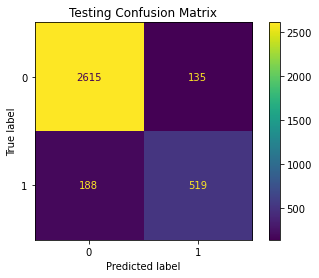

In [20]:
#Let's look at the confusion matrix for the test
cm = metrics.confusion_matrix(y_test, y_pred_test)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Testing Confusion Matrix")
plt.show()

In [21]:
# print message text for the false positives (negative tweets incorrectly labeled as positive)
X_test[y_test < y_pred_test].head(20)

2163     thank reply emailed customer care department e...
7968       best pleased service far gate guarantee correct
7532     thank correctly interpreting tweet non sarcast...
5396                      rt fleet fleek httptconcguzdgdaq
4849     just wanted southwest know think great used an...
5958     jetblue thanks including u tour did pack winte...
1897     thank reply frustration spending upgrade just ...
3362     quick response offering assistance lack follow...
4311     city nationwide sale ha fabulous fare buffalo ...
3083     thanks reaching seat wa hard cushion ok short ...
10189    really appreciate great customer service servi...
10892                              finally got phone worry
9646                                          bot haha lie
2177     loyalty team basically flipped phone thanks ma...
8965     saving grace wa flight attendant dallas wa ama...
4523         landing ric right left atl picked delta maybe
5444     thank really responding request sending generi.

We can see words like "thank", "best", "quick", "fabulous", "appreciate", etc. were in the tweets that were incorrectly labeled as positive. We can see that this classifier is not very good at picking up sarcasm.

#### Identify Strongly Predictive Features

In [25]:
words = np.array(vect.get_feature_names())

x = np.eye(X_test_dtm.shape[1])
probs = nb.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

pred_strength = pd.DataFrame({'tokens':words, 'probability':1-np.exp(probs)})

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
        best airline 0.94
            passbook 0.94
      awesome thanks 0.93
            guy rock 0.92
        thanks quick 0.91
           wonderful 0.91
         great thank 0.91
        great flight 0.90
           fantastic 0.90
        thanks great 0.89
Bad words	     P(fresh | word)
                fail 0.02
        disappointed 0.02
                  hr 0.02
      flight delayed 0.01
             luggage 0.01
                rude 0.01
           hold hour 0.01
              online 0.01
    flight cancelled 0.01
               worst 0.01


In [26]:
pred_strength.sort_values('probability')

,tokens,probability
4520,worst,0.006799
1351,flight cancelled,0.008837
2816,online,0.009468
1932,hold hour,0.009728
3397,rude,0.011161
...,...,...
3933,thanks quick,0.913866
1808,guy rock,0.921078
279,awesome thanks,0.932399
2884,passbook,0.940880


## Modeling by Airline

We now want to build the model to classify positive and negative tweets for each airline as well as find the strongly predictive words for each. To do so, we will first attempt this by splitting the dataset by airline and modeling individually. We will then try to accomplish this by adding a new column that includes both sentiment and airline, and try to model as a multi-class classification. 

In [67]:
df_united = df[df['airline']=='United']
df_usairways = df[df['airline']=='US Airways']
df_american = df[df['airline']=='American']
df_southwest = df[df['airline']=='Southwest']
df_delta = df[df['airline']=='Delta']
df_virginam = df[df['airline']=='Virgin America']

In [80]:
def sentiments_by_airline(df_input):
    #Define train and test sets
    X_df = df_input.text_clean
    y_df = df_input.sentiment_num

    Xtr, Xte, ytr, yte = train_test_split(X_df, y_df, test_size = 0.3, stratify=y_df, random_state=1)

    #Use CountVectorizer with same parameters from final model before
    vect = CountVectorizer(max_df = grid_cv_nb.best_params_['vectorizer__max_df'], 
                           min_df = grid_cv_nb.best_params_['vectorizer__min_df'], 
                           ngram_range = grid_cv_nb.best_params_['vectorizer__ngram_range'])
    Xtr_dtm = vect.fit_transform(Xtr)
    Xte_dtm = vect.transform(Xte)

    #Train NB model and find accuracy for train and test sets
    nb = MultinomialNB(alpha = grid_cv_nb.best_params_['classifier__alpha'])
    nb.fit(Xtr_dtm, ytr)
    print ("Accuracy on training data: %0.3f" % (nb.score(Xtr_dtm, ytr)))
    print ("Accuracy on test data:     %0.3f" % (nb.score(Xte_dtm, yte)))
    
    #Same process as before to find top words and ngrams for positive and negative sentiments
    words = np.array(vect.get_feature_names())

    x = np.eye(Xte_dtm.shape[1])
    probs = nb.predict_log_proba(x)[:, 0]
    ind = np.argsort(probs)

    good_words = words[ind[:15]]
    bad_words = words[ind[-15:]]

    good_prob = probs[ind[:15]]
    bad_prob = probs[ind[-15:]]

    pred_strength = pd.DataFrame({'tokens':words, 'probability':1-np.exp(probs)})

    print("Good words\t     P(fresh | word)")
    for w, p in zip(good_words, good_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
    print("Bad words\t     P(fresh | word)")
    for w, p in zip(bad_words, bad_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

### United

In [81]:
sentiments_by_airline(df_united)

Accuracy on training data: 0.937
Accuracy on test data:     0.904
Good words	     P(fresh | word)
         thanks help 0.87
               kudos 0.81
               worry 0.81
               cheer 0.81
          thank help 0.81
            bringing 0.78
        great flight 0.78
           good work 0.78
        global class 0.78
           follow dm 0.78
     thanks checking 0.78
               thank 0.76
             amazing 0.69
           excellent 0.69
            deserves 0.69
Bad words	     P(fresh | word)
               think 0.03
      delayed flight 0.03
              booked 0.03
        disappointed 0.03
             flightr 0.03
        late flightr 0.03
                long 0.03
              minute 0.03
                hour 0.03
             sitting 0.03
                said 0.03
               stuck 0.03
           passenger 0.02
                 say 0.02
               worst 0.01


We see that the positive sentiments include a lot of ngrams including thanks, excellent, checking - they are all celebrating a good experience and showing appreciation for good service. The negative sentiments include lots of words involving time and delays, as well as showing disappointment in booking experience. 

### US Airways

In [82]:
sentiments_by_airline(df_usairways)

Accuracy on training data: 0.949
Accuracy on test data:     0.918
Good words	     P(fresh | word)
               kudos 0.82
           did great 0.79
         best follow 0.79
           wonderful 0.79
               shout 0.75
        great people 0.75
              follow 0.71
                  fa 0.69
         thanks help 0.65
               super 0.65
               thank 0.65
           great job 0.60
              hoping 0.60
        flight thank 0.60
             amazing 0.60
Bad words	     P(fresh | word)
                  hr 0.02
                 doe 0.02
                 min 0.02
                line 0.02
        late flightr 0.02
             sitting 0.02
             flightr 0.02
                told 0.02
           hold hour 0.02
                mile 0.02
               worst 0.01
             waiting 0.01
                hour 0.01
              minute 0.01
                hold 0.01


The positive sentiments seem to show appreciation to the staff, flight attendents, etc. while the negative sentiments again seem to show disappointment to time related things. We see the words "mile" and "hold" which may signify the customers are having a poor experience with phone service and redeeming mileage points. 

### American

In [83]:
sentiments_by_airline(df_american)

Accuracy on training data: 0.954
Accuracy on test data:     0.894
Good words	     P(fresh | word)
               photo 0.86
                safe 0.81
        great thanks 0.81
                 aww 0.81
           fantastic 0.81
           excellent 0.81
               thank 0.81
        photo thanks 0.78
             amazing 0.78
               sweet 0.78
      awesome thanks 0.78
         thanks help 0.78
               kudos 0.78
          appreciate 0.72
               great 0.69
Bad words	     P(fresh | word)
           cancelled 0.03
              answer 0.03
    cancelled flight 0.03
               phone 0.03
              online 0.03
                want 0.03
                hour 0.02
               worst 0.02
    flight cancelled 0.02
                told 0.02
              trying 0.02
             waiting 0.01
                  hr 0.01
                need 0.01
                hold 0.01


For American, lots of similar words, though we do see "safe" which may show American is doing a good job in putting an emphasis on safety for the passengers. The negative sentiments seem to largely be directed at cancelled flights and phone service which is something this airline may want to pay attention to. 

### Southwest

In [84]:
sentiments_by_airline(df_southwest)

Accuracy on training data: 0.915
Accuracy on test data:     0.858
Good words	     P(fresh | word)
             awesome 0.96
            passbook 0.93
               thank 0.91
        best airline 0.91
             amazing 0.90
                 god 0.89
              lauren 0.87
                rock 0.87
              oh god 0.87
                 lol 0.87
            favorite 0.87
                fast 0.87
                 fan 0.87
             sent dm 0.85
      love southwest 0.85
Bad words	     P(fresh | word)
              answer 0.07
              refund 0.06
               phone 0.06
               stuck 0.06
               worst 0.05
                hour 0.05
 cancelled flightled 0.05
           flightled 0.05
             luggage 0.05
    flight cancelled 0.04
                 min 0.03
              online 0.03
           hold hour 0.03
                  hr 0.02
                hold 0.02


We see the same sort of positive words here, and even a specific name of an employee most likely (seems she needs a raise!!). The negative sentiment words seem to have similar ideas of cancellations, luggage (most likely missing), as well as refund (perhaps lots of difficulty in receiving one). 

### Delta

In [85]:
sentiments_by_airline(df_delta)

Accuracy on training data: 0.904
Accuracy on test data:     0.840
Good words	     P(fresh | word)
               thank 0.93
        great flight 0.93
                rock 0.91
               great 0.88
              thanks 0.88
            love guy 0.87
          bluemanity 0.87
            guy rock 0.87
             awesome 0.87
         thanks help 0.85
      awesome thanks 0.85
            favorite 0.85
        thanks quick 0.85
               video 0.85
               reply 0.85
Bad words	     P(fresh | word)
               delay 0.08
               hotel 0.08
                late 0.08
      flight delayed 0.08
  cancelled flighted 0.08
            flighted 0.08
                left 0.08
                  hr 0.08
             sitting 0.07
                told 0.07
                  pm 0.07
           cancelled 0.06
         late flight 0.05
             delayed 0.05
                hour 0.02


Similar positive words as other airline, negative words include hotel, which may indicate trouble in booking hotel due to cancellation or poor hotel choice due to cancellation, etc. 

### Virgin America

In [86]:
sentiments_by_airline(df_virginam)

Accuracy on training data: 0.893
Accuracy on test data:     0.750
Good words	     P(fresh | word)
               great 0.92
                love 0.92
               route 0.90
              austin 0.88
              thanks 0.86
            love guy 0.86
                best 0.85
             america 0.83
                rock 0.83
                wish 0.83
              faster 0.83
                cool 0.81
    customer service 0.79
             amazing 0.79
             awesome 0.76
Bad words	     P(fresh | word)
             luggage 0.15
               phone 0.15
                 jfk 0.15
             website 0.15
                need 0.15
 cancelled flightled 0.13
             checkin 0.13
           flightled 0.13
              broken 0.13
                 bag 0.12
              trying 0.10
               check 0.09
                help 0.09
           cancelled 0.08
                seat 0.06


Lastly, the positive words for Virgin America are similar once again, with customer service showing up as well. Negative words indicate problems with check-in, flight seats, website, phone service, as well as luggage and bags. 